# Linear Regression with Gradient Descent (California Housing Dataset) - One Feature

In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import matplotlib.pyplot as plt

### 1. Introduction

This notebook implements linear regression using gradient descent to predict median house values in California, based on the 'MedInc' (median income) feature from the California Housing dataset."

In [5]:
# Load the California Housing dataset. This dataset is suitable for regression tasks.
housing = fetch_california_housing()
# Create a Pandas DataFrame from the features, using the feature names for columns.
california_df = pd.DataFrame(housing.data, columns=housing.feature_names)
# Add the target variable (Median House Value) to the DataFrame.
california_df['MedHouseVal'] = housing.target

In [7]:
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### 2. Data Exploration

The California Housing dataset contains information about housing prices in California districts. Each row represents a census block group, and the columns describe various attributes of that region. We will explore the relationship between the features and the target variable, Median House Value ('MedHouseVal'), to determine which features are most relevant for predicting house prices.

The 'MedInc' feature represents the median income in each block group, measured in tens of thousands of dollars. We expect that 'MedInc' will have a positive correlation with 'MedHouseVal', as areas with higher median incomes typically have higher property values.

To understand the relationship between the features and the target variable (MedHouseVal), we use a scatter plot matrix. This helps us identify potential linear relationships that are suitable for linear regression.


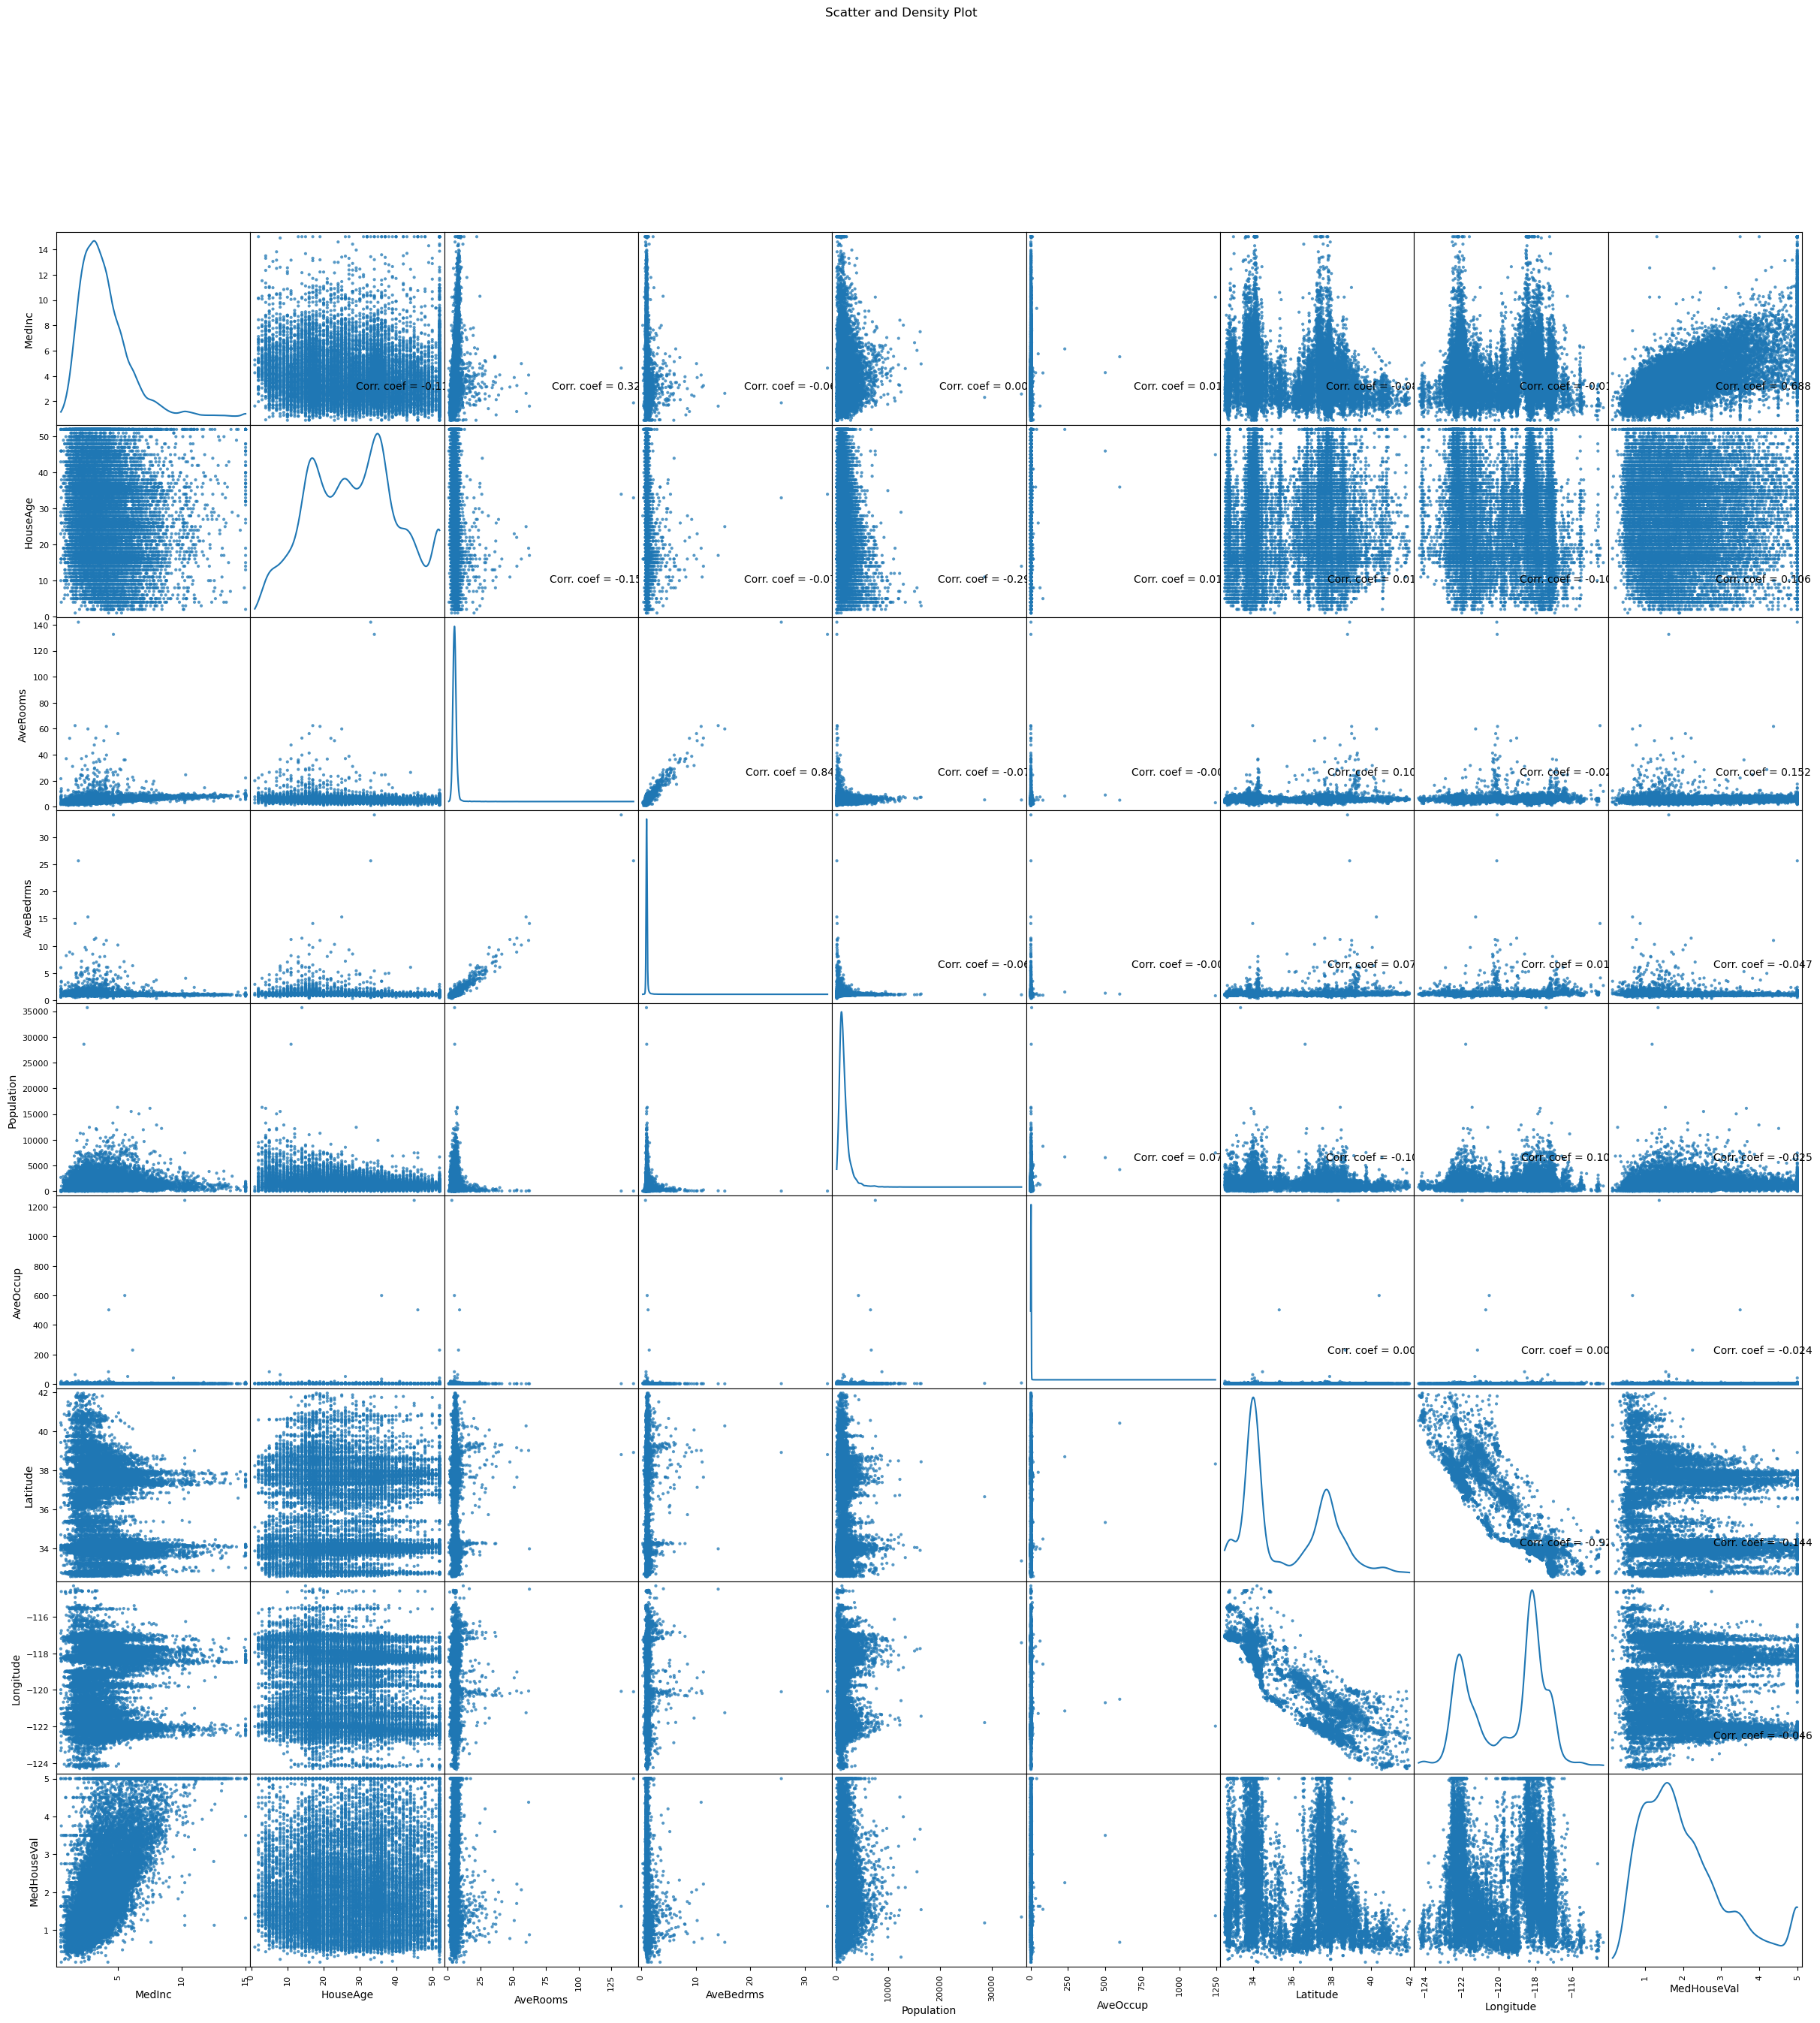

In [9]:
# Visualize linearity: A scatter plot matrix is generated to assess the relationships between numerical variables.  This helps determine if linear regression is appropriate, as the model assumes a linear relationship between the independent and dependent variables.
def plotScatterMatrix(df, plotSize, textSize):
    df = california_df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis = 'columns') # drop columns containing missing values 
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
plotScatterMatrix(california_df, 30, 10)

#### Scatter Plot Comments
The scatter plot matrix reveals that 'MedInc' exhibits the strongest linear relationship with 'MedHouseVal'. While the relationship is noisy, the general upward trend suggests that higher median incomes are associated with higher house prices. Other features, such as 'AveRooms' and 'HouseAge', show weaker or non-linear relationships with the target variable.

### 3. Model Implementation 
This project uses linear regression to model the relationship between median income and median house prices in California. Linear regression aims to find the line that best predicts the target variable (house price) based on the input feature (median income).

#### 3.1 Linear Regression Model
A linear model that predicts $f_{w,b}(x^{(i)})$ is defined as:
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$

Where:
- $x^{(i)}$ is the median income for the (i)-th block group (the input feature).
- $w$ is the weight or slope, representing the change in predicted house price for a one-unit change in median income.
- $b$ is the bias or y-intercept, representing the predicted house price when the median income is zero.

The goal of linear regression is to find the optimal values for the parameters $w$ and $b$ that minimize the difference between the model's predictions and the actual house prices.
#### 3.2 The Cost Function (MSE)
To measure the model's performance, we use the *Mean Squared Error (MSE) cost function*, $J(w,b)$. The MSE calculates the average of the squared differences between the predicted prices and the actual prices:

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$$ 
Where:

- $m$ is the number of training examples (block groups).
- $y^{(i)}$ is the actual median house price for the (i)-th block group.

The cost function quantifies how well the model is performing; a lower cost indicates better predictions.

(In linear regression, we use input training data *(X_train)* to fit the parameters $w$,$b$ by minimizing a measure of the error between our predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$)

#### 3.2 Gradient Descent Summary

*Gradient descent* is an iterative optimization algorithm used to find the values of $w$ and $b$ that minimize the cost function $J(w,b)$. The algorithm works by repeatedly updating the parameters in the direction of the steepest descent of the cost function's gradient.

The parameters $w$ and $b$ are updated simultaneously using the following equations:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
Where:

- $\alpha$ is the learning rate, a positive scalar that controls the step size of each update.
- $\frac{\partial J(w,b)}{\partial w}$ is the partial derivative of the cost function with respect to $w$.
- $\frac{\partial J(w,b)}{\partial b}$ is the partial derivative of the cost function with respect to $b$.
Note: here *simultaniously* means that partial derivatives are calculated before updating any of the parameters.

The partial derivatives are calculated as follows:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

These equations calculate the gradient of the cost function with respect to $w$ and $b$, indicating the direction in which the cost function increases most rapidly. By subtracting a fraction $(\alpha)$ of this gradient from the current parameter values, we move closer to the minimum of the cost function.

In [11]:
X = california_df[['MedInc']].values  # Independent variable (Median Income)       - feature
y = california_df['MedHouseVal'].values  # Dependent variable (Median House Value) - target value

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Difine the Cost Function: J(w,b)
def compute_cost(x, y, w, b):
    """
    Computes the Cost Function J(w,b)
    Args:
      x (ndarray (m,)): Data, m examples
      y (ndarray (m,)): target values
      w,b (scalar)     : model parameters
    Returns
      the Cost function J
    """
    m = x.shape[0]
    cost = 0

    for i in range(m):
        f_wb = w * x[i] + b
        cost = cost + (f_wb - y[i])**2
    total_cost = 1 / (2 * m) * cost # as defined in (2)

    return total_cost

# Defining the Gradient as defined in (4) & (5)
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      x (ndarray (m,)): Data, m examples
      y (ndarray (m,)): target values
      w,b (scalar)     : model parameters
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b
    """

    # Number of training examples
    m = x.shape[0]
    dj_dw = 0 # initialise dj_dw
    dj_db = 0 # initialise dj_db

    for i in range(m):
        f_wb = w * x[i] + b
        dj_dw_i = (f_wb - y[i]) * x[i] # as defined in (4)
        dj_db_i = f_wb - y[i]         # as defined in (5)
        dj_db += dj_db_i
        dj_dw += dj_dw_i
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_dw, dj_db

# Defining the Gradient Descent Algorithm
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function):
    """
    Performs gradient descent to fit w,b. Updates w,b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      x (ndarray (m,))  : Data, m examples
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters
      alpha (float):       Learning rate
      num_iters (int):     number of iterations to run gradient descent
      cost_function:       function to call to produce cost
      gradient_function: function to call to produce gradient

    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b]
    """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w , b)       

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db
        w = w - alpha * dj_dw       

        # Save cost J at each iteration
        if i<100000:       # prevent resource exhaustion
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")

    return w, b, J_history, p_history # return w and J,w history for graphing

# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2

# Reshape X_train
X_train = X_train.reshape(-1)

# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(X_train ,y_train, w_init, b_init, tmp_alpha,
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 1.95e+00  dj_dw: -9.561e+00, dj_db: -2.072e+00   w:  9.561e-02, b: 2.07195e-02
Iteration 1000: Cost 3.50e-01  dj_dw:  2.072e-03, dj_db: -9.876e-03   w:  4.305e-01, b: 3.91584e-01
Iteration 2000: Cost 3.50e-01  dj_dw:  3.221e-04, dj_db: -1.536e-03   w:  4.211e-01, b: 4.36355e-01
Iteration 3000: Cost 3.50e-01  dj_dw:  5.008e-05, dj_db: -2.388e-04   w:  4.196e-01, b: 4.43316e-01
Iteration 4000: Cost 3.50e-01  dj_dw:  7.787e-06, dj_db: -3.712e-05   w:  4.194e-01, b: 4.44398e-01
Iteration 5000: Cost 3.50e-01  dj_dw:  1.211e-06, dj_db: -5.772e-06   w:  4.193e-01, b: 4.44566e-01
Iteration 6000: Cost 3.50e-01  dj_dw:  1.882e-07, dj_db: -8.974e-07   w:  4.193e-01, b: 4.44592e-01
Iteration 7000: Cost 3.50e-01  dj_dw:  2.927e-08, dj_db: -1.395e-07   w:  4.193e-01, b: 4.44597e-01
Iteration 8000: Cost 3.50e-01  dj_dw:  4.550e-09, dj_db: -2.169e-08   w:  4.193e-01, b: 4.44597e-01
Iteration 9000: Cost 3.50e-01  dj_dw:  7.075e-10, dj_db: -3.373e-09   w:  4.193e-01, b: 4.44597e-01


##### Cost Function Visualization:

The plot below shows the value of the cost function, $J(w,b)$, at each iteration of the gradient descent algorithm. This visualization provides insights into:
- **Convergence**: A decreasing cost function confirms that the gradient descent algorithm is working correctly and converging towards optimal parameter values.
- **Learning Rate**: The plot helps assess the learning rate, $\alpha$. A very slow decrease suggests that a larger $\alpha$ might be needed, while fluctuations or increases indicate that  $\alpha$ is too large.
- **Iteration Count**: The plot aids in determining the required number of iterations. The algorithm should continue until the cost function reaches a plateau, indicating convergence.

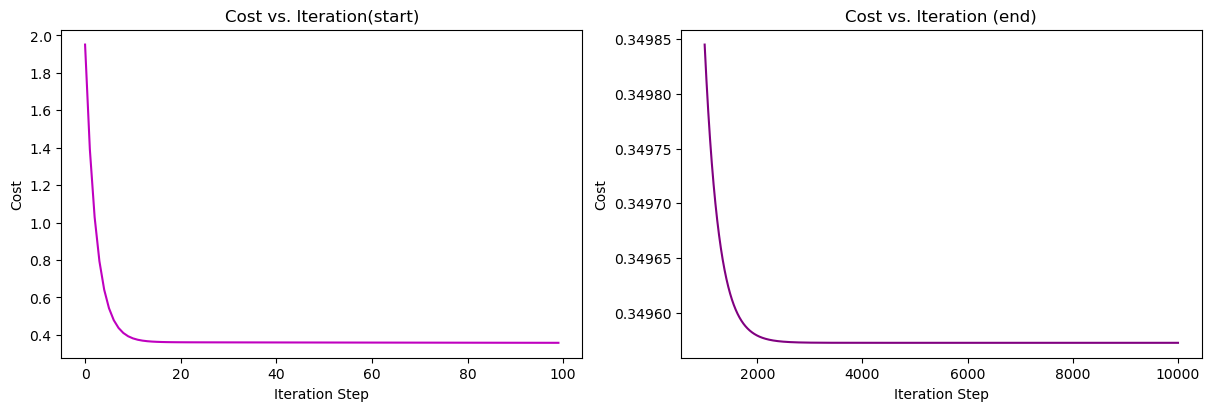

In [17]:
# Plot cost versus iteration  - Cost should always decrease in successful runs
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100],c='m')
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:], c='purple')
ax1.set_title("Cost vs. Iteration(start)");  ax2.set_title("Cost vs. Iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('Iteration Step')  ;  ax2.set_xlabel('Iteration Step') 
plt.show()

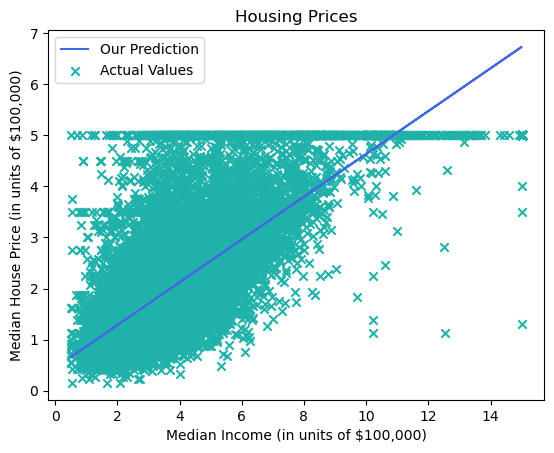

In [19]:
w = 0.4193
b = 0.4446
def compute_model_output(x, w, b):
    """
    Computes the prediction of a linear model
    Args:
      x (ndarray (m,)): Data, m examples 
      w,b (scalar)    : model parameters  
    Returns
      f_wb (ndarray (m,)): model prediction
    """
    m = x.shape[0]
    f_wb = np.zeros(m)
    for i in range(m):
        f_wb[i] = w * x[i] + b
        
    return f_wb
tmp_f_wb = compute_model_output(X_train, w, b,)

# Plot our model prediction
plt.plot(X_train, tmp_f_wb, c='royalblue',label='Our Prediction')

# Plot the data points
plt.scatter(X_train, y_train, marker='x', c='lightseagreen',label='Actual Values')

# Set the title
plt.title("Housing Prices")
# Set the y-axis label
plt.ylabel('Median House Price (in units of $100,000)')
# Set the x-axis label
plt.xlabel('Median Income (in units of $100,000)')
plt.legend()
plt.show()

In [21]:
# 1. Calculate predictions on training and test sets
train_predictions = compute_model_output(X_train, w_final, b_final)
test_predictions = compute_model_output(X_test, w_final, b_final)


# 2. Calculate MSE for training and test sets
train_mse = compute_cost(X_train, y_train, w_final, b_final)
X_test = X_test.reshape(-1) # reshaping X_test same as X_train
test_mse = compute_cost(X_test, y_test, w_final, b_final)


# 3. Print the MSE values
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Training MSE: 0.3496
Test MSE: 0.3546


/var/folders/k9/0y_csq093j9bk7nrfcvc_0h80000gp/T/ipykernel_1043/599086872.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_wb[i] = w * x[i] + b


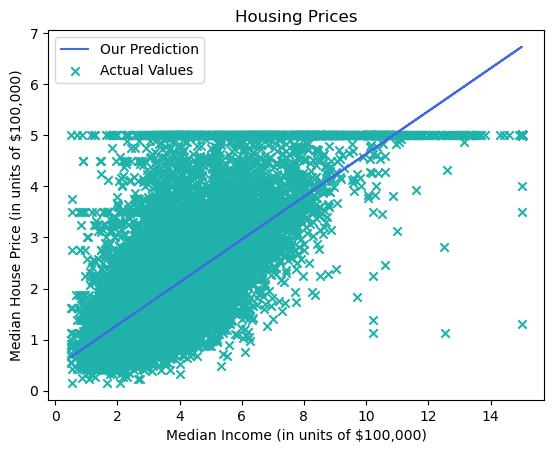

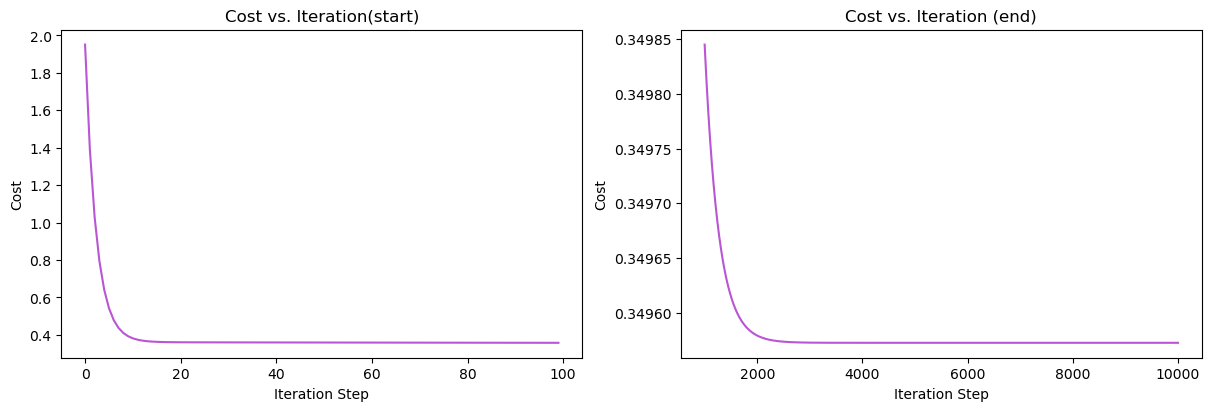

In [23]:
# Plot our model prediction
plt.plot(X_train, train_predictions, c='royalblue', label='Our Prediction')

# Plot the data points
plt.scatter(X_train, y_train, marker='x', c='lightseagreen', label='Actual Values')

# Set the title
plt.title("Housing Prices")
# Set the y-axis label
plt.ylabel('Median House Price (in units of $100,000)')
# Set the x-axis label
plt.xlabel('Median Income (in units of $100,000)')
plt.legend()
plt.show()

# plot cost versus iteration  - Cost should always decrease in successful runs
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist[:100], color = 'mediumorchid')
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:], color = 'mediumorchid')
ax1.set_title("Cost vs. Iteration(start)");
ax2.set_title("Cost vs. Iteration (end)")
ax1.set_ylabel('Cost');
ax2.set_ylabel('Cost')
ax1.set_xlabel('Iteration Step');
ax2.set_xlabel('Iteration Step')
plt.show()

### 4. Conclusion 
The current linear regression model presented in this notebook, trained with only a single feature, provided a foundational understanding of the algorithm's mechanics. As anticipated, the predictions were limited to a simple straight line, which proved to be quite inaccurate and unable to capture the true complexity and often non-linear patterns observed in real-world housing data.

This basic model serves primarily to illustrate the fundamental concept of linear regression. Its simplicity clearly highlights the necessity of providing more comprehensive and suitably prepared information to achieve meaningful predictive power.

Therefore, the next steps in this analysis will involve:

- Incorporating multiple features: To provide a richer context for predictions.

- Applying feature scaling (normalization): To ensure efficient and stable convergence of the Gradient Descent algorithm.

- Exploring initial feature engineering: To enable the linear model to capture more nuanced relationships beyond a single straight line.

These crucial improvements will be detailed and analyzed in the subsequent notebooks.